In [5]:
import pandas as pd
import numpy as np
import glob
import os

def rms(x):
    return np.sqrt(np.mean(x**2))

def kurtosis(x):
    return x.kurtosis()

In [6]:
caso = input("DIGITE O NUMERO DO CASO (Train_): ")
caminho_pasta = f"../Train/Train_{caso}/"
arquivo_rul = f"{caminho_pasta}F_{caso}_RUL.csv"
try:
    with open(arquivo_rul, 'r') as f:
        linha = f.readline()
        nCiclos = int(linha.strip())
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em {caminho_pasta}")

dados_processados = []
nomes_colunas = [
    "Duration", "Ref_Pos", "Fbk_Pos", "Ref_Vel", "Fbk_Vel", 
    "Fbk_Hall", "Fbk_Enc", "Vbus", "Temp_Motor", 
    "Corrente_A", "Corrente_B", "Corrente_C", 
    "Temp_Driver", "Volt_A", "Volt_B", "Volt_C"
]


## Leitura dos valores de cada ciclo

In [7]:
x_max_anterior = 190.0
ciclo_falha_real= None
for i in range(1, nCiclos + 1):
    # Organiza os arquivos de abertura e fechamento
    file_open = f"{caminho_pasta}F_{caso}_{i:05d}_Opening.csv"
    file_close = f"{caminho_pasta}F_{caso}_{i:05d}_Closing.csv"
    if not os.path.exists(file_open) or not os.path.exists(file_close):
        continue
    df_open = pd.read_csv(file_open, sep=';', header=None, names=nomes_colunas)
    df_close = pd.read_csv(file_close, sep=';', header=None, names=nomes_colunas)

    features = {'Ciclo': i}
    
    x_max_atual = df_open['Fbk_Pos'].iloc[0] # Onde o fechamento realmente parou
    x_max_close = df_close['Fbk_Pos'].iloc[599]
    features['X_max_Atual'] = x_max_atual
    delta = x_max_anterior - x_max_atual
    features['Tamanho_do_Choque'] = delta
    x_max_anterior = x_max_atual
    features['Perda'] = (190 - x_max_atual)
    
    features['Lag_Posicao'] = (df_close['Ref_Pos'] - df_close['Fbk_Pos']).mean()
    features['Contexto_Velocidade'] = df_close['Fbk_Vel'].abs().mean()
    features['RMSE Velocidade'] = np.sqrt(((df_close['Ref_Vel'] - df_close['Fbk_Vel'])**2).mean())
    features['Desvio_Padrao_Velocidade'] = df_close['Fbk_Vel'].std()

    features['Corr_A_RMS'] = np.sqrt((df_close['Corrente_A']**2).mean())
    features['Corr_B_RMS'] = np.sqrt((df_close['Corrente_B']**2).mean())
    features['Corr_C_RMS'] = np.sqrt((df_close['Corrente_C']**2).mean())

    features['Corr_A_Max'] = df_close['Corrente_A'].abs().max()
    features['Corr_B_Max'] = df_close['Corrente_B'].abs().max()
    features['Corr_C_Max'] = df_close['Corrente_C'].abs().max()

    features['Hall_open'] = df_open['Fbk_Hall'].median()
    features['Hall_close'] = df_close['Fbk_Hall'].median()
    
    if x_max_atual < 19 and ciclo_falha_real is None:
            ciclo_falha_real = i

    dados_processados.append(features)
      

## Plotar o gráfico geral a cada ciclo e identificar os pontos de choque

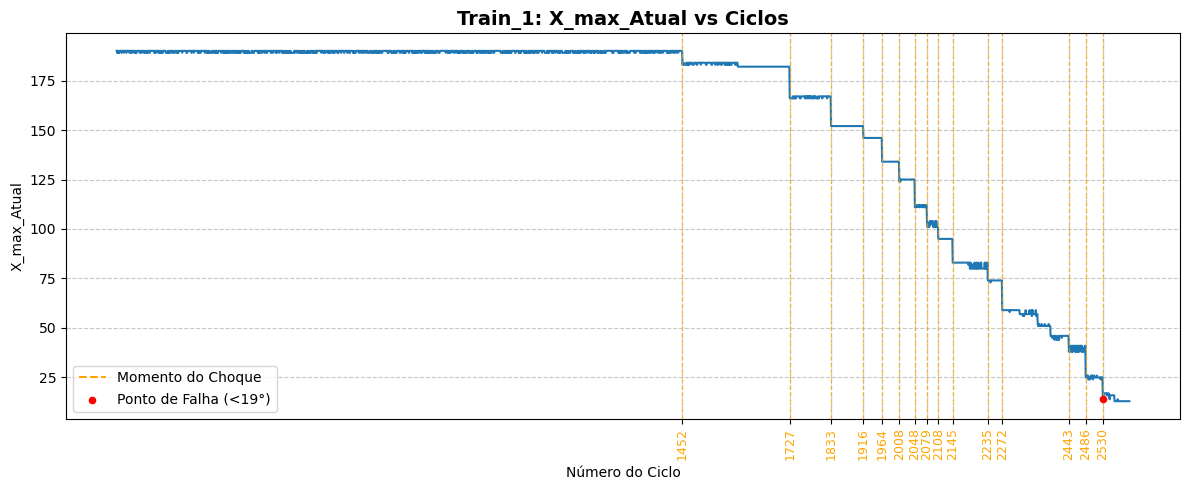

In [8]:
import matplotlib.pyplot as plt

df_final = pd.DataFrame(dados_processados)
colunas_para_plotar = ['X_max_Atual', 'Perda']

plt.figure(figsize=(12, 5)) # Tamanho da figura (Largura, Altura)

# Plotagem: X=Ciclo, Y=Coluna Atual
plt.plot(df_final['Ciclo'], df_final['X_max_Atual'], color='#1f77b4', linewidth=1.5)
ciclos_com_choque = df_final[df_final['Tamanho_do_Choque'] > 5]['Ciclo']
# Adiciona uma linha vertical para cada choque
for ciclo_choque in ciclos_com_choque:
    plt.axvline(x=ciclo_choque, color='orange', linestyle='--', alpha=0.6, linewidth=1)
plt.plot([], [], color='orange', linestyle='--', label='Momento do Choque')


plt.xticks(ciclos_com_choque, rotation=90, fontsize=9, color='orange')

# Estilização
plt.title(f'Train_{caso}: X_max_Atual vs Ciclos', fontsize=14, fontweight='bold')
plt.xlabel('Número do Ciclo', fontsize=10)
plt.ylabel('X_max_Atual', fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Destaque visual: Onde a falha ocorre (último ciclo)
linha_da_falha = df_final[df_final['Ciclo'] == ciclo_falha_real]
if not linha_da_falha.empty:
    x_falha = linha_da_falha['Ciclo'].values[0]
    y_falha = linha_da_falha['X_max_Atual'].values[0]
    plt.scatter(x_falha, y_falha, color='red', s=20, zorder=5, label='Ponto de Falha (<19°)')
else:
    print(f"Aviso: O ciclo de falha {ciclo_falha_real} não foi encontrado neste DataFrame.")
plt.legend()

plt.tight_layout()
plt.show()

## Plotar features dos ciclos próximos aos pontos de choque

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# --- PREPARAÇÃO ---
colunas_ignoradas = ['Ciclo', 'X_max_Atual', 'Perda', 'Tamanho_do_Choque']
todas_features = [col for col in df_final.columns if col not in colunas_ignoradas]
lista_choques = list(ciclos_com_choque) # Garante que é lista

# --- FUNÇÃO DE PLOTAGEM ---
def plot_assimetrico(features_selecionadas, choques_selecionados, janela_depois):
    
    if not features_selecionadas or not choques_selecionados:
        print("Selecione Features e Choques.")
        return

    # Janela Fixa para frente (Futuro)
    janela_antes = 50 

    for feature in features_selecionadas:
        for ciclo_choque in choques_selecionados:
            
            plt.figure(figsize=(20, 5))
            
            # 1. DEFINE O INTERVALO ASSIMÉTRICO
            # Começa 'janela_antes' atrás e termina '20' na frente
            inicio = ciclo_choque - janela_antes
            fim = ciclo_choque + janela_depois
            
            # 2. FILTRA OS DADOS
            # Agora filtramos pelo número real do ciclo
            dados = df_final[(df_final['Ciclo'] >= inicio) & (df_final['Ciclo'] <= fim)]
            
            if dados.empty:
                print(f"Sem dados para o intervalo {inicio}-{fim}")
                continue

            # 3. PLOTA COM EIXO X ABSOLUTO
            # Usamos dados['Ciclo'] no eixo X para mostrar os números reais (1184, 1194...)
            plt.plot(dados['Ciclo'], dados[feature], 
                     marker='o', markersize=4, linewidth=2, color='#1f77b4',
                     label=f'Feature: {feature}')

            # 4. CONFIGURAÇÃO DOS TICKS (DE 10 EM 10)
            # Cria uma lista de números começando do 'inicio', indo até 'fim', pulando de 10 em 10
            ticks_x = np.arange(inicio, fim + 1, 10)
            plt.xticks(ticks_x, rotation=45, fontweight='bold', fontsize=10)

            # 5. DESTAQUES VISUAIS
            # Linha vermelha no momento exato do choque
            plt.axvline(ciclo_choque, color='red', linestyle='--', label=f'Choque (Ciclo {ciclo_choque})')
            
            # Marca o ponto exato na linha
            valor_no_choque = df_final.loc[df_final['Ciclo'] == ciclo_choque, feature]
            if not valor_no_choque.empty:
                plt.scatter(ciclo_choque, valor_no_choque, color='red', s=100, zorder=5)

            plt.title(f'Análise: {feature} | Choque no Ciclo {ciclo_choque}', fontsize=14, fontweight='bold')
            plt.ylabel(feature, fontsize=12)
            plt.xlabel('Número Real do Ciclo', fontsize=12)
            plt.grid(True, linestyle=':', alpha=0.6)
            plt.legend()
            plt.tight_layout()
            plt.show()

# --- WIDGETS ---

widget_features = widgets.SelectMultiple(
    options=todas_features,
    value=[todas_features[0]],
    description='Features:',
    rows=5
)

widget_choques = widgets.SelectMultiple(
    options=lista_choques,
    value=[lista_choques[0]] if lista_choques else [],
    description='Choques:',
    rows=5
)

# O Slider controla apenas o PASSADO (a janela antes)
widget_janela = widgets.IntSlider(
    value=100,
    min=60, 
    max=300, 
    step=20,
    description='Janela:', # Deixei claro no nome
    continuous_update=False
)

ui = widgets.HBox([widget_features, widget_choques])
ui_final = widgets.VBox([ui, widget_janela])

out = widgets.interactive_output(plot_assimetrico, {
    'features_selecionadas': widget_features,
    'choques_selecionados': widget_choques,
    'janela_depois': widget_janela
})

display(ui_final, out)

Output()